# 04 - Recurrent Highway Networks
By Jan Christian Blaise B. Cruz

In the past notebooks, we've been building up on architectures that had a Long-Short Term Memory (Hochreiter & Schmidhuber, 1997) as the model backbone. In this notebook, we'll explore the use of a different recurrence strategy and a new architecture, called Recurrent Highway Networks (Zilly et al., 2017).

Let's start with the imports.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torchtext.data import Field, BPTTIterator
from torchtext.datasets import PennTreebank
import spacy

import numpy as np
import pandas as pd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

We'll use the Torchtext library to load and prepare our dataset. Again, we'll use the Penn Treebank, splitting them into train, valid, and test sets, tokenizing them with SpaCy's english tokenizer, and building the vocabulary with words of frequency of at least 2.

In [15]:
# Tokenizer
spacy_en = spacy.load('en')
def tokenize(s):
    return [tok.text for tok in spacy_en.tokenizer(s)]

# Prepare a field and get the data
TEXT = Field(lower=True, tokenize=tokenize)
train_data, valid_data, test_data = PennTreebank.splits(TEXT)

# Build the vocabulary
TEXT.build_vocab(train_data, min_freq=2)
print("Vocab size: {}".format(len(TEXT.vocab)))

Vocab size: 9702


We'll batch them, again using the ```BPTTIterator``` following common conventions on batch size and sequence length.

In [0]:
batch_size = 40
bptt_len = 35

train_loader, valid_loader, test_loader = BPTTIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=batch_size, bptt_len=bptt_len, 
    device=device, 
    repeat=False
)

For convenience, we'll define recurrent dropout like we did in the previous notebooks.

In [0]:
# Credits to the contributors at fast.ai
def dropout_mask(x, sz, p):
    return x.new(*sz).bernoulli_(1-p).div_(1-p)
  
class RNNDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p=p

    def forward(self, x):
        if not self.training or self.p == 0.: 
          return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m

# Motivations


Before we dive in to **Recurrent Highway Networks**, we first set some movitvations.

### Residual Layers

A **Residual connection** (He et al., 2015) in a neural network is a mechanism that mitigates vanishing gradients via "skip connections" that allow smooth gradient flow. Using residual connections aid in training of deep neural networks and this has been shown over time with empirical results. Given an input vector $x \in \mathbb{R}^n$, the output for a certain layer in a residual neural network is given by:

$$y = f(W x + b) + x$$

where $W$ and $b$ are the weight matrix and the bias vector of the layer and $f$ is a nonlinear activation function. Residual layers have success stories in many applications and have found homes in state-of-the-art architectures, such as the ResNet (He et al., 2015) series in computer vision, and BERT (Devlin et al., 2019) in natural language processing. 

### Highway Layers

A modification to the residual layer is the **Highway Layer** (Srivastava et al.,  2015a). Inspired by gating mechanisms in the Long-Short Term Memory (Hochreiter & Schmidhuber, 1997), the highway layer uses gates to control how much information to pass and how much information to retain from the skip connection via learned weights.

Given $h = H(x, W_H)$, $t = T(x, W_T)$, and $c = C(x, W_C)$ where $h$, $t$, and $c$ are the results of nonlinear transforms $H$, $T$, and $C$ with associated weight matrices $W_{H, T, C}$ and biases $b_{H, T, C}$, the output $y$ of a highway layer is computed as:

$$y = h \odot t + x \odot c$$

Where $\odot$ is the hadamard (elementwise) product operation. In practice, $H$ often uses the $tanh$ nonlinearity, and the $T$ and $C$ use the sigmoid ($\sigma$) nonlinearity.

$H$ can often be thought of as the "main non-linear transform" of the input $x$. $T$ and $C$ act as gates, controling from a range of $[0, 1]$ how much of the transformed input and the original input are to be carried over. In practice, a suggestion from the Highway networks paper is to couple the $C$ gate to the output of the $T$ gate by setting $C(\cdot) = 1 - T(\cdot)$. This reduces the parameters to optimize and could prevent an unbounded blow-up of states, which makes optimization smoother. However, this imposes a modeling bias, which could prove suboptimal for certain tasks (Greff et al., 2015; Jozefowicz et al., 2015).

### Recurrrent Highways
A **Recurrent Highway** (Zilly et al., 2017) adapts the idea of a highway layer to include a recurrence mechanism, acting as a drop-in replacement for LSTMs or other gated-RNNs for a variety of sequence modeling tasks. An improvement that recurrent highways have is a timestep-to-timestep transition larger than one, as opposed to common gated-RNNs.

Recall that a general RNN transition given $s$ timesteps is in the form:

$$y^{[s]} = f(Wx^{[s]} + Ry^{[s - 1]} + b)$$

A one-depth Recurrent Highway Network transition is given by:

$$ h^{[s]} = tanh(W_{H}x^{[s]} + R_{H}y^{[s - 1]} + b) $$
$$ t^{[s]} = \sigma(W_{T}x^{[s]} + R_{T}y^{[s - 1]} + b) $$
$$ c^{[s]} = 1 - t^{[s]} $$
$$ y^{[s]} = h^{[s]} \odot t^{[s]} + y^{[s - 1]} \odot c^{[s]} $$

By stacking multiple recurrent highways on top of each other, we could achieve a larger timestep-to-timestep transition. Given $L$ layers,  $l = \{1, 2, ..., L\}$ "ticks" in each timestep, and $s_l$ as the intermediate output between stacked layers, the recurrence can be expanded to:

$$h^{[s]}_l = tanh(W_Hx^{[s]}\mathcal{I}_{\{l=1\}} + R_{H_l}s^{[s]}_{l-1} + b_{H_l})$$
$$t^{[s]}_l = \sigma(W_Tx^{[s]}\mathcal{I}_{\{l=1\}} + R_{T_l}s^{[s]}_{l-1} + b_{T_l})$$
$$c^{[s]}_l = \sigma(W_Cx^{[s]}\mathcal{I}_{\{l=1\}} + R_{C_l}s^{[s]}_{l-1} + b_{C_l})$$
$$s^{[t]}_0 = y^{[t-1]}$$
$$s^{[t]}_l = h^{[s]}_l \odot t^{[s]}_l + s^{[t]}_l-1 \odot c^{[s]}_l$$

where $\mathcal{I}$ is the indicator function. Like in the standard highway layer and the one-depth recurrent highway, the $C$ and $T$ gates can be coupled setting $c^{[s]}_l = 1 - t^{[s]}_l$, reducing the numer of parameters to optimize. We can introduce recurrent dropout (Semeniuta et al., 2014) on $t$ as a one hyperparameter for all layers. The recurrent highway can be used as a drop-in replacement to any gated-RNN cell in any sequence-modeling architecture.

We construct our highway layer block such that it can be used as a standard highway layer or can be stacked in a recurrent highway layer. The ```first``` argument should set to ```True``` when stacking (see indicator function when $l = 1$ in the equations.) We can set the option to ```couple``` $C$ and $T$ as well. We also use recurrent dropout on $t$ as needed.

In [0]:
class HighwayBlock(nn.Module):
    """ Highway Layer Block. Can be used as a highway layer or stacked into a recurrent highway. """
    def __init__(self, in_features, out_features, first=False, couple=False, dropout=0.0):
        super(HighwayBlock, self).__init__()
        self.first = first
        self.couple = couple
        if first:
            self.W_H = nn.Linear(in_features, out_features, bias=False)
            self.W_T = nn.Linear(in_features, out_features, bias=False)
            if not couple: self.W_C = nn.Linear(in_features, out_features, bias=False)
        self.R_H = nn.Linear(in_features, out_features)
        self.R_T = nn.Linear(in_features, out_features)
        if not couple: self.R_C = nn.Linear(in_features, out_features)
        self.dropout = RNNDropout(dropout)
    
    def forward(self, x, s):
        if self.first:
            h = torch.tanh(self.W_H(x) + self.R_H(x))
            t = torch.sigmoid(self.W_T(x) + self.R_T(x))
            if self.couple:
                c = 1 - t
            else:
                c = torch.sigmoid(self.W_C(x) + self.R_C(x))
        else:
            h = torch.tanh(self.R_H(x))
            t = torch.sigmoid(self.R_T(x))
            if self.couple:
                c = 1 - t
            else:
                c = torch.sigmoid(self.R_C(x))
        t = self.dropout(t.unsqueeze(0)).squeeze(0)
        
        return h * t + s * c

The recurrent highway is simply a wrapper for a stacked highway block. We overload ```forward``` to apply the recurrence. In practice, this layer can be used as a direct replacement for a gated-RNN layer, and functions quite similar to a Gated Recurrent Unit (Cho et al., 2014) albeit with a larger timestep-to-timestep transition.

Like other RNN layers, it expects inputs of dimensions ```[seq_len, bs, inp_dim]```. We definte it like so.

In [0]:
class RecurrentHighway(nn.Module):
    """Recurrent Highway Layer. Stacks highway blocks with a recurrence mechanism. Replaces LSTM/GRU."""
    def __init__(self, in_features, out_features, recurrence_depth=5, couple=False, dropout=0):
        super(RecurrentHighway, self).__init__()
        self.highways = [HighwayBlock(in_features, out_features, 
                                      first=True if l == 0 else False, 
                                      couple=couple, dropout=dropout) for l in range(recurrence_depth)]
        self.highways = nn.ModuleList(self.highways)
        self.recurrence_depth=recurrence_depth
        self.hidden_dim = out_features
    
    def forward(self, inp, hidden):
        # expects input dimensions [seq_len, bs, inp_dim]
        outputs = []
        for x in inp:
            for block in self.highways:
                hidden = block(x, hidden)
                
            outputs.append(hidden)
        outputs = torch.stack(outputs)
        return outputs, hidden

# Recurrent Highway Language Model

We can then adapt this to a language model architecture. We explicitly separate multiple layers of recurrent highways so that we can use "hidden-to-hidden" dropout as a regularization tactic. We also add in the option to tie the weights.

In [0]:
class RHNLanguageModel(nn.Module):
    def __init__(self, vocab_sz, embedding_dim, hidden_dim, recurrence_depth=1, 
                 num_layers=1, hidden_dp=0.65, recur_dp=0.3, tie_weights=True, couple=False):
        super(RHNLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_sz, embedding_dim)
        self.rnns = [RecurrentHighway(embedding_dim if l == 0 else hidden_dim, 
                                      (hidden_dim if l != num_layers - 1 else embedding_dim) if tie_weights else hidden_dim, 
                                      recurrence_depth=recurrence_depth, couple=couple, dropout=recur_dp) for l in range(num_layers)]
        self.rnns = nn.ModuleList(self.rnns)
        self.fc1 = nn.Linear(embedding_dim if tie_weights else hidden_dim, vocab_sz)
        self.hidden_dropout = RNNDropout(hidden_dp)
        
        if tie_weights:
            self.fc1.weight = self.embedding.weight
        
    def init_hidden(self, bs):
        # Returns a list of zeroed hidden states of dimensions [bs, hidden_dim]
        weight = next(self.parameters()).data
        hidden = [weight.new(bs, rnn.hidden_dim).zero_() for rnn in self.rnns]
        
        return hidden
    
    def forward(self, x):
        bptt_len, bs = x.shape
        vocab_sz = self.embedding.num_embeddings
        
        out = self.embedding(x) 
        
        hiddens = self.init_hidden(bs)
        for i, rnn in enumerate(self.rnns):
          out, hidden = rnn(out, hiddens[i])
          out = self.hidden_dropout(out)

        out = self.fc1(out.flatten(0, 1))
        out = out.view(bptt_len, bs, vocab_sz)
        return out

We instantiate a model and initialize its parameters between $[-0.01, 0.01]$. We'll optimize the network via the Adam optimizer (KIngma & Ba, 2014) using a cross-entropy objective. We'll use two layers with a hidden size of $650$ units. We'll tie the encoder and projection weights. This is reminiscent of the architecture used by Press & Wolf (2016), which in turn was based on the setup of Zaremba et al. (2014).

We choose to use a recurrence depth of 5 and couple $C$ and $T$ to reduce parameters. We'll apply $0.3$ recurrent dropout to $t$ and $0.65$ to the "hidden-to-hidden" connections between the recurrent layers.

In [71]:
model = RHNLanguageModel(vocab_sz=len(TEXT.vocab), embedding_dim=300, hidden_dim=650, 
                         recurrence_depth=5, num_layers=2, recur_dp=0.3, hidden_dp=0.65, 
                         tie_weights=True, couple=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.01, 0.01)
        
model.apply(init_weights)            
print("The model has {:,} trainable parameters".format(count_parameters(model)))

The model has 7,609,802 trainable parameters


We train it for 40 epochs, saving the model as validation loss decreases.

In [72]:
epochs = 40
train_losses = []
valid_losses = []
best = np.inf

for e in range(1, epochs + 1):
    model.train()    
    train_loss = 0 
    for batch in tqdm(train_loader):
        x, y = batch.text, batch.target
        out = model(x)
        
        loss = criterion(out.flatten(0, 1), y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_ppl = np.exp(train_loss)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            x, y = batch.text, batch.target
            out = model(x)
            loss = criterion(out.flatten(0, 1), y.flatten())

            valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    valid_ppl = np.exp(valid_loss)
    valid_losses.append(valid_loss)
    
    if valid_loss < best:
        best = valid_loss
        torch.save({'state_dict': model.state_dict()}, 'rhn.pth')
    
    print("\nEpoch {:3d} | Train Loss {:.4f} | Valid Loss {:.4f} | Train Ppl {:.4f} | Valid Ppl {:.4f}".format(e, train_loss, valid_loss, train_ppl, valid_ppl))

  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   1 | Train Loss 6.4903 | Valid Loss 5.8666 | Train Ppl 658.7384 | Valid Ppl 353.0360


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   2 | Train Loss 5.6708 | Valid Loss 5.3738 | Train Ppl 290.2679 | Valid Ppl 215.6906


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   3 | Train Loss 5.3197 | Valid Loss 5.1101 | Train Ppl 204.3157 | Valid Ppl 165.6794


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   4 | Train Loss 5.1056 | Valid Loss 4.9288 | Train Ppl 164.9512 | Valid Ppl 138.2204


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   5 | Train Loss 4.9780 | Valid Loss 4.8309 | Train Ppl 145.1893 | Valid Ppl 125.3243


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   6 | Train Loss 4.8974 | Valid Loss 4.7597 | Train Ppl 133.9452 | Valid Ppl 116.7142


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   7 | Train Loss 4.8360 | Valid Loss 4.7047 | Train Ppl 125.9622 | Valid Ppl 110.4628


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   8 | Train Loss 4.7873 | Valid Loss 4.6606 | Train Ppl 119.9719 | Valid Ppl 105.6943


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch   9 | Train Loss 4.7429 | Valid Loss 4.6207 | Train Ppl 114.7612 | Valid Ppl 101.5620


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  10 | Train Loss 4.7042 | Valid Loss 4.5860 | Train Ppl 110.4110 | Valid Ppl 98.1029


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  11 | Train Loss 4.6730 | Valid Loss 4.5568 | Train Ppl 107.0227 | Valid Ppl 95.2814


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  12 | Train Loss 4.6434 | Valid Loss 4.5328 | Train Ppl 103.8986 | Valid Ppl 93.0188


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  13 | Train Loss 4.6182 | Valid Loss 4.5083 | Train Ppl 101.3162 | Valid Ppl 90.7631


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  14 | Train Loss 4.5947 | Valid Loss 4.4870 | Train Ppl 98.9600 | Valid Ppl 88.8573


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  15 | Train Loss 4.5710 | Valid Loss 4.4691 | Train Ppl 96.6429 | Valid Ppl 87.2802


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  16 | Train Loss 4.5515 | Valid Loss 4.4516 | Train Ppl 94.7758 | Valid Ppl 85.7660


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  17 | Train Loss 4.5324 | Valid Loss 4.4368 | Train Ppl 92.9788 | Valid Ppl 84.5015


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  18 | Train Loss 4.5149 | Valid Loss 4.4202 | Train Ppl 91.3645 | Valid Ppl 83.1124


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  19 | Train Loss 4.4975 | Valid Loss 4.4108 | Train Ppl 89.7901 | Valid Ppl 82.3364


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  20 | Train Loss 4.4833 | Valid Loss 4.3991 | Train Ppl 88.5307 | Valid Ppl 81.3787


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  21 | Train Loss 4.4669 | Valid Loss 4.3860 | Train Ppl 87.0836 | Valid Ppl 80.3168


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  22 | Train Loss 4.4540 | Valid Loss 4.3724 | Train Ppl 85.9672 | Valid Ppl 79.2351


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  23 | Train Loss 4.4413 | Valid Loss 4.3628 | Train Ppl 84.8860 | Valid Ppl 78.4778


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  24 | Train Loss 4.4279 | Valid Loss 4.3557 | Train Ppl 83.7560 | Valid Ppl 77.9221


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  25 | Train Loss 4.4169 | Valid Loss 4.3449 | Train Ppl 82.8365 | Valid Ppl 77.0872


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  26 | Train Loss 4.4041 | Valid Loss 4.3357 | Train Ppl 81.7886 | Valid Ppl 76.3799


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  27 | Train Loss 4.3942 | Valid Loss 4.3274 | Train Ppl 80.9818 | Valid Ppl 75.7475


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  28 | Train Loss 4.3826 | Valid Loss 4.3165 | Train Ppl 80.0483 | Valid Ppl 74.9246


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  29 | Train Loss 4.3723 | Valid Loss 4.3095 | Train Ppl 79.2228 | Valid Ppl 74.4023


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  30 | Train Loss 4.3615 | Valid Loss 4.3039 | Train Ppl 78.3774 | Valid Ppl 73.9873


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  31 | Train Loss 4.3544 | Valid Loss 4.2953 | Train Ppl 77.8233 | Valid Ppl 73.3549


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  32 | Train Loss 4.3442 | Valid Loss 4.2917 | Train Ppl 77.0325 | Valid Ppl 73.0931


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  33 | Train Loss 4.3358 | Valid Loss 4.2808 | Train Ppl 76.3894 | Valid Ppl 72.2964


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  34 | Train Loss 4.3261 | Valid Loss 4.2754 | Train Ppl 75.6486 | Valid Ppl 71.9065


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  35 | Train Loss 4.3168 | Valid Loss 4.2703 | Train Ppl 74.9488 | Valid Ppl 71.5404


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  36 | Train Loss 4.3102 | Valid Loss 4.2648 | Train Ppl 74.4575 | Valid Ppl 71.1502


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  37 | Train Loss 4.3024 | Valid Loss 4.2583 | Train Ppl 73.8737 | Valid Ppl 70.6903


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  38 | Train Loss 4.2943 | Valid Loss 4.2517 | Train Ppl 73.2774 | Valid Ppl 70.2243


  0%|          | 0/170 [00:00<?, ?it/s]


Epoch  39 | Train Loss 4.2854 | Valid Loss 4.2453 | Train Ppl 72.6297 | Valid Ppl 69.7795


100%|██████████| 14/14 [00:02<00:00,  5.31it/s]


Epoch  40 | Train Loss 4.2782 | Valid Loss 4.2413 | Train Ppl 72.1117 | Valid Ppl 69.4991


Let's see the loss curves.

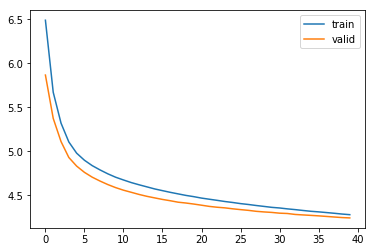

In [74]:
pd.DataFrame(data={'train':train_losses, 'valid':valid_losses}).plot.line()

We'll load the best model and evaluate on the test set.

In [78]:
checkpoint = torch.load('rhn.pth')
model.load_state_dict(checkpoint['state_dict'])

model.eval()
test_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = batch.text, batch.target
        out = model(x)
        loss = criterion(out.flatten(0, 1), y.flatten())

        test_loss += loss.item()
test_loss /= len(test_loader)
test_ppl = np.exp(test_loss)

print("\nTest Loss {:.4f} | Test Ppl {:.4f}".format(test_loss, test_ppl))

100%|██████████| 16/16 [00:02<00:00,  5.77it/s]


Test Loss 4.0991 | Test Ppl 60.2868


We got a test perplexity of ~60 with a two-layer recurrent highway network with a depth of 5. The best score on the paper was ~66 with a recurrence depth of 9. Do note that in the original paper, the authors only tested single layer networks in order to study the effect of the recurrence depth, and mentioned that stacking more layers will give better test scores.

This is our best score so far!

Let's implement beam search and try to generate text.

In [0]:
# This implementation deffo could use some work. I just wrote this
# from the top of my head after a couple drinks HAHA. If you see any
# errors, don't be afraid to reach out!
def get_candidates(text, score, k=5):
  s = torch.LongTensor([TEXT.vocab.stoi[w] for w in tokenize(text)]).unsqueeze(0)
  out = model(s)
  probs = torch.softmax(out.squeeze(0)[-1], dim=0)
  scores, indices = torch.topk(probs, k)
  words = [TEXT.vocab.itos[i] for i in indices]
  checks = set(['<', '>', 'unk', '<eos>', '<sos>'])
  candidates = [text + " " + c for c in words if c not in checks]
  scores = scores * score
  return scores, candidates

def beam_search(text, n_words, k):
  scores, cands = get_candidates(text, 1)
  for i in tqdm(range(n_words)):
    ncands = []
    nscores = []
    for s, c in zip(scores, cands):
      ns, nc = get_candidates(c, s, k=k)
      ncands.extend(nc)
      nscores.extend(ns)
    scores = []
    cands = []
    for c, s in sorted(list(zip(ncands, nscores)), key=lambda x: x[1], reverse=True)[:k]:
      scores.append(s)
      cands.append(c)
  return cands[0]

Let's test it.

In [367]:
n_words = 15
k = 10
text = "the meaning of life is"

out = beam_search(text, n_words, k)
print('\n' + out)

100%|██████████| 15/15 [00:01<00:00, 10.12it/s]


the meaning of life is expected the company said mr   but it has grown from new england said mr and
